## Generate Docstring for Python Functions (2 Epochs)

Dataset Source: https://huggingface.co/datasets/calum/the-stack-smol-python-docstrings

#### Install Necessary Libraries

In [1]:
%pip install rouge_score

Note: you may need to restart the kernel to use updated packages.


#### Import Necessary Libraries

In [2]:
import os, sys

import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from transformers import AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import set_seed, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

import torch
from torch.utils.data import DataLoader

import datasets
from datasets import load_dataset, DatasetDict, Dataset
import evaluate

!git lfs install

NOTE: Redirects are currently not supported in Windows or MacOs.


Git LFS initialized.


#### Display Library Versions

In [3]:
n = 18

print("Library/Language:".rjust(n), "Version")
print("Python:".rjust(n), sys.version[0:6])
print("NumPy:".rjust(n), np.__version__)
print("Pandas:".rjust(n), pd.__version__)
print("Torch:".rjust(n), torch.__version__)
print("Datasets:".rjust(n), datasets.__version__)
print("Transformers:".rjust(n), transformers.__version__)
print("Evaluate:".rjust(n), evaluate.__version__)

 Library/Language: Version
           Python: 3.9.12
            NumPy: 1.24.2
           Pandas: 1.5.0
            Torch: 1.12.1
         Datasets: 2.9.0
     Transformers: 4.26.1
         Evaluate: 0.4.0


#### Ingest Dataset

In [4]:
dataset = load_dataset("calum/the-stack-smol-python-docstrings")

dataset

Using custom data configuration calum--the-stack-smol-python-docstrings-21ab0798f01e04a9
Found cached dataset parquet (/Users/briandunn/.cache/huggingface/datasets/calum___parquet/calum--the-stack-smol-python-docstrings-21ab0798f01e04a9/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


A Jupyter Widget

DatasetDict({
    train: Dataset({
        features: ['body', 'body_hash', 'docstring', 'path', 'name', 'repository_name', 'lang', 'body_without_docstring'],
        num_rows: 24616
    })
})

#### Convert to Pandas DataFrame

In [5]:
dataset.set_format("pandas")
df = dataset['train'][:]

df

,body,body_hash,docstring,path,name,repository_name,lang,body_without_docstring
0,def _canonicalize_experiment(exp):\n 'Sorts...,-8215901732217586742,Sorts the repeated fields of an Experiment mes...,tensorboard/plugins/hparams/backend_context_te...,_canonicalize_experiment,aryaman4/tensorboard,python,def _canonicalize_experiment(exp):\n \n ...
1,"def __init__(self, request_id=None, return_cod...",2894216753114153542,ResumeProcessesResponse - a model defined in S...,lib/services/vautoscaling/ncloud_vautoscaling/...,__init__,NaverCloudPlatform/ncloud-sdk-python,python,"def __init__(self, request_id=None, return_cod..."
2,@property\ndef request_id(self):\n 'Gets th...,-1183890875359341296,Gets the request_id of this ResumeProcessesRes...,lib/services/vautoscaling/ncloud_vautoscaling/...,request_id,NaverCloudPlatform/ncloud-sdk-python,python,@property\ndef request_id(self):\n 'Gets th...
3,"@request_id.setter\ndef request_id(self, reque...",-8333445982014422093,Sets the request_id of this ResumeProcessesRes...,lib/services/vautoscaling/ncloud_vautoscaling/...,request_id,NaverCloudPlatform/ncloud-sdk-python,python,"@request_id.setter\ndef request_id(self, reque..."
4,@property\ndef return_code(self):\n 'Gets t...,5002841652600357537,Gets the return_code of this ResumeProcessesRe...,lib/services/vautoscaling/ncloud_vautoscaling/...,return_code,NaverCloudPlatform/ncloud-sdk-python,python,@property\ndef return_code(self):\n 'Gets t...
...,...,...,...,...,...,...,...,...
24611,@read_session\ndef list_identities(session=Non...,-8399802736883936158,Returns a list of all identities.\n\n:param se...,lib/rucio/core/identity.py,list_identities,Pranay144/rucio,python,@read_session\ndef list_identities(session=Non...
24612,@read_session\ndef list_accounts_for_identity(...,7104951005997468497,Returns a list of all accounts for an identity...,lib/rucio/core/identity.py,list_accounts_for_identity,Pranay144/rucio,python,@read_session\ndef list_accounts_for_identity(...
24613,def test_plain_ansi(self):\n '\n Tes...,2886767279122754110,Test that printable characters do not get mang...,evennia/server/portal/tests.py,test_plain_ansi,Antrare/evennia,python,def test_plain_ansi(self):\n '\n \n ...
24614,def test_identity(self):\n '\n Test ...,-7974552474826718259,Test that the composition of the function and\...,evennia/server/portal/tests.py,test_identity,Antrare/evennia,python,def test_identity(self):\n '\n Test ...


#### Drop unnecessary features & Other Text Cleaning

In [6]:
df = df.drop(columns=["repository_name", "path", "body_hash", "body_without_docstring", "lang", "name"])

df = df.rename(columns={"body": "text"})
df['text'] = df['text'].apply(lambda x: x.strip())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24616 entries, 0 to 24615
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       24616 non-null  object
 1   docstring  24616 non-null  object
dtypes: object(2)
memory usage: 384.8+ KB


#### Remove Docstring From Functions

In [7]:
df['text'] = df['text'].apply(lambda x: x.replace(x.split("'")[1], ""))

df

,text,docstring
0,def _canonicalize_experiment(exp):\n ''\n ...,Sorts the repeated fields of an Experiment mes...
1,"def __init__(self, request_id=None, return_cod...",ResumeProcessesResponse - a model defined in S...
2,@property\ndef request_id(self):\n ''\n ...,Gets the request_id of this ResumeProcessesRes...
3,"@request_id.setter\ndef request_id(self, reque...",Sets the request_id of this ResumeProcessesRes...
4,@property\ndef return_code(self):\n ''\n ...,Gets the return_code of this ResumeProcessesRe...
...,...,...
24611,@read_session\ndef list_identities(session=Non...,Returns a list of all identities.\n\n:param se...
24612,@read_session\ndef list_accounts_for_identity(...,Returns a list of all accounts for an identity...
24613,def test_plain_ansi(self):\n ''\n irc_an...,Test that printable characters do not get mang...
24614,def test_identity(self):\n ''\n s = '|wt...,Test that the composition of the function and\...


#### Visualize: Word Length of Code (Input)

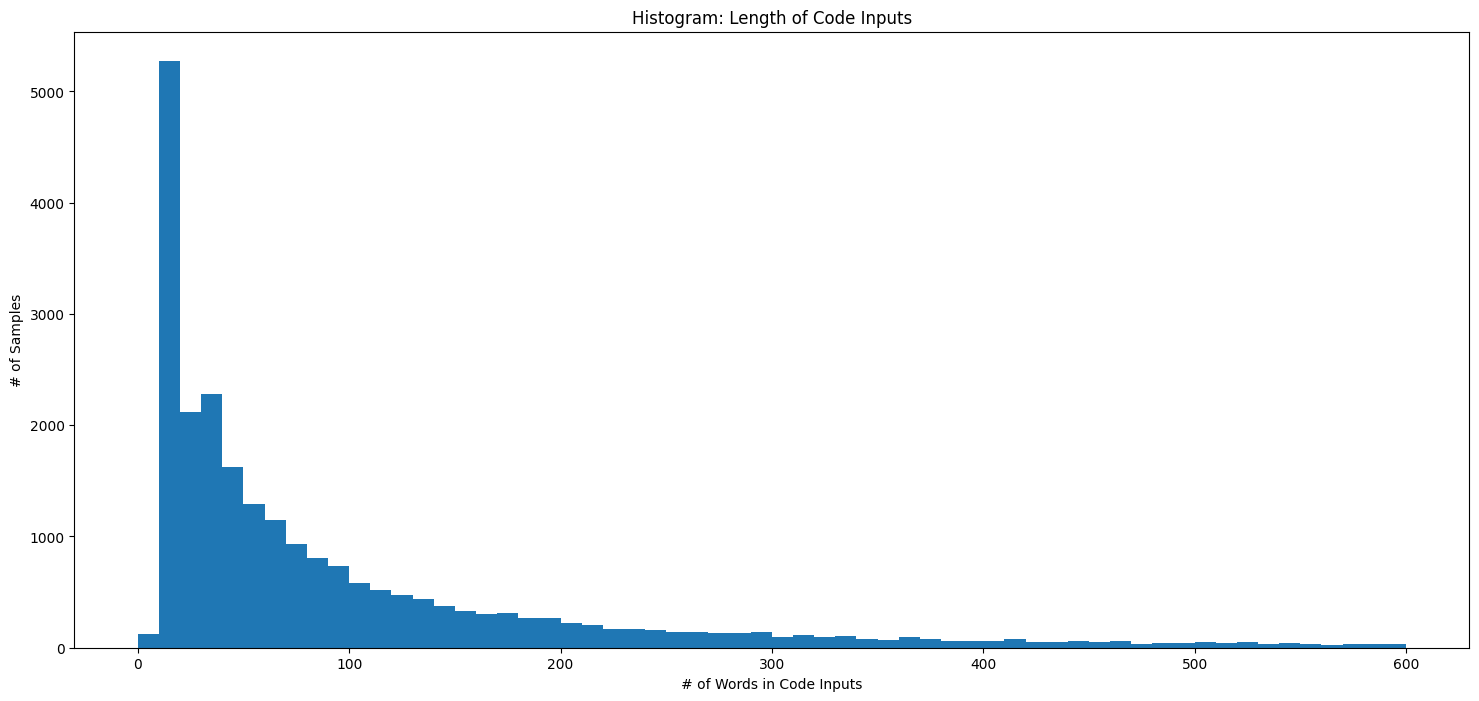

The maximum length of Code Inputs (in words) is 11431 words.


In [8]:
df['code_length'] = df['text'].str.split(" ").str.len()

n_bin=600
df.hist('code_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=int(n_bin/10))
plt.title('Histogram: Length of Code Inputs')
plt.xlabel('# of Words in Code Inputs')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Code Inputs (in words) is {max(df['code_length'])} words.")

#### Visualize: Word Length of Docstrings (Output)

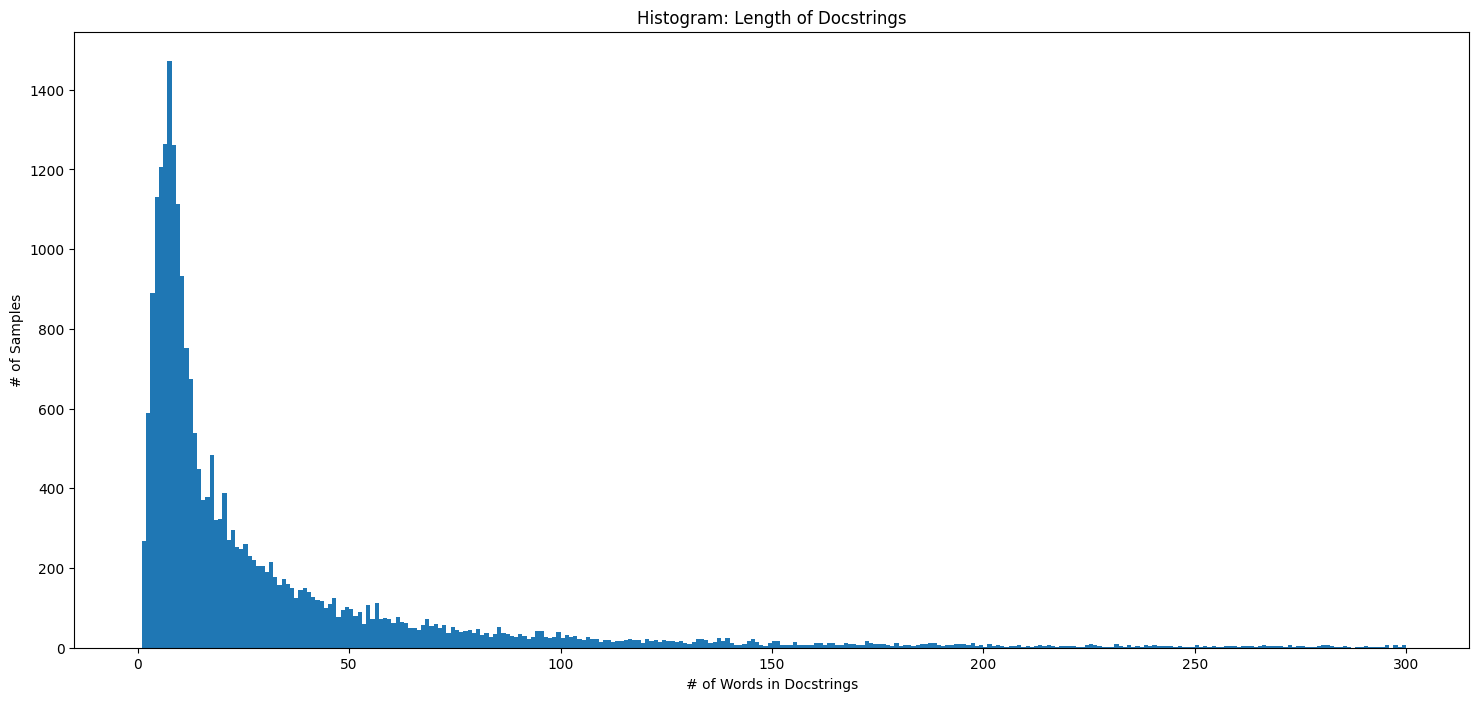

The maximum length of Docstrings (in words) is 3954 words.


In [9]:
df['docstring_length'] = df['docstring'].str.split(" ").str.len()

n_bin=300
df.hist('docstring_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Docstrings')
plt.xlabel('# of Words in Docstrings')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Docstrings (in words) is {max(df['docstring_length'])} words.")

#### Trim Overly Lengthy Code Samples & Docstrings as Well as Remove Unnecessary Features

In [10]:
df = df[df['code_length'] < 250]
df = df[df['docstring_length'] < 125]

df = df.drop(columns=['code_length', 'docstring_length'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20581 entries, 0 to 24615
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       20581 non-null  object
 1   docstring  20581 non-null  object
dtypes: object(2)
memory usage: 482.4+ KB


#### Convert DataFrame Back to Dataset

In [11]:
dataset = Dataset.from_pandas(df)

#### Split Code into Training/Testing/Evaluation Datasets

In [12]:
train_valid = dataset.train_test_split(train_size=0.75)

ds = DatasetDict({
    'train': train_valid['train'], 
    'eval': train_valid['test']})

print('Training data shape:', ds['train'].shape)
print('Validation data shape:', ds['eval'].shape)

Training data shape: (15435, 3)
Validation data shape: (5146, 3)


#### Print an Example

In [13]:
example = ds['train'][5]

print("Code:\n", example["text"])
print("\nDocstring:\n", example["docstring"])

Code:
 @staticmethod
def _convert_to_time_range(interval):
    ''
    TS_FORMAT = '%Y-%m-%dT%H:%M:%S'
    get_digits = (lambda s: int(''.join(filter(str.isdigit, s))))
    get_alpha = (lambda s: ''.join(filter(str.isalpha, s)))
    ts_parts = interval.split(' ')
    start = ' '.join(ts_parts[0:(len(ts_parts) - 2)])
    minus = get_digits(ts_parts[(- 2)])
    plus = get_digits(ts_parts[(- 1)])
    interval = get_alpha(ts_parts[(- 1)])
    start_ts = parser.parse(start)
    rd = relativedelta.relativedelta
    if (interval == 's'):
        start_range = (start_ts - rd(seconds=minus))
        end_range = (start_ts + rd(seconds=plus))
    elif (interval == 'm'):
        start_range = (start_ts - rd(minutes=minus))
        end_range = (start_ts + rd(minutes=plus))
    elif (interval == 'h'):
        start_range = (start_ts - rd(hours=minus))
        end_range = (start_ts + rd(hours=plus))
    elif (interval == 'd'):
        start_range = (start_ts - rd(days=minus))
        end_range = (star

#### Basic Values/Constants

In [14]:
MODEL_CKPT = "Salesforce/codet5-small"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Generate_Docstrings_for_Python-Condensed"

T5_PREFIX = "Summarize python: "
NUM_OF_EPOCHS = 4

REPORTS_TO = "tensorboard"
STRATEGY = "epoch"

DEVICE = torch.device("cpu")
set_seed = 42

LR = 2e-5
BATCH_SIZE = 16

#### Instantiate Tokenizer

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

#### Define Function for Preprocessing Dataset

In [16]:
def preprocess_samples(samples):
    codes = samples['text']
    docstrings = samples['docstring']
    
    inputs = [T5_PREFIX + code for code in codes]
    model_inputs = tokenizer(inputs,
                             padding="max_length", 
                             truncation=True)
    
    labels = tokenizer(docstrings,
                       padding="max_length", 
                       truncation=True
                       ).input_ids
    
    labels_with_ignore_index = []
    for label_ex in labels:
        label_ex = [label if label != 0 else -100 for label in label_ex]
        labels_with_ignore_index.append(label_ex)
    
    model_inputs["labels"] = labels_with_ignore_index
    
    return model_inputs

#### Apply Preprocessing Function to Dataset

In [17]:
encoded_ds = ds.map(preprocess_samples, 
                         batched=True)

A Jupyter Widget

A Jupyter Widget

#### Check That Preprocessing Worked as Expected

In [18]:
encoded_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'docstring', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 15435
    })
    eval: Dataset({
        features: ['text', 'docstring', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5146
    })
})

#### Define Data Collator

In [19]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=MODEL_CKPT)

#### Define Function to Compute Metrics

In [20]:
rouge_metric = evaluate.load("rouge")

def compute_metrics(preds):
    predictions, labels = preds
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

#### Define Model

In [21]:
model = (AutoModelForSeq2SeqLM.from_pretrained(MODEL_CKPT)).to(DEVICE)

#### Define TrainingArguments

In [22]:
args = Seq2SeqTrainingArguments(output_dir=MODEL_NAME,
                         num_train_epochs=NUM_OF_EPOCHS,
                         report_to=REPORTS_TO,
                         learning_rate=LR,
                         logging_strategy=STRATEGY,
                         logging_steps=100,
                         evaluation_strategy=STRATEGY,
                         per_device_train_batch_size=BATCH_SIZE,
                         per_device_eval_batch_size=BATCH_SIZE,
                         save_strategy=STRATEGY,
                         predict_with_generate=True,
                         logging_first_step=True,
                         hub_private_repo=True,
                         push_to_hub=True
                         )

#### Define Trainer

In [23]:
trainer = Seq2SeqTrainer(model=model,
                  args=args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer,
                  train_dataset=encoded_ds['train'],
                  eval_dataset=encoded_ds['eval'])

Cloning https://huggingface.co/DunnBC22/codet5-small-Generate_Docstrings_for_Python-Condensed into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

#### Train Model

In [24]:
training_results = trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: __index_level_0__, text, docstring. If __index_level_0__, text, docstring are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 15435
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3860
  Number of trainable parameters = 60492288


A Jupyter Widget

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 7.3204, 'learning_rate': 1.9994818652849742e-05, 'epoch': 0.0}


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: __index_level_0__, text, docstring. If __index_level_0__, text, docstring are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5146
  Batch size = 16
Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



{'loss': 2.9064, 'learning_rate': 1.5000000000000002e-05, 'epoch': 1.0}


A Jupyter Widget

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

{'eval_loss': 2.3095991611480713, 'eval_rouge1': 0.3695, 'eval_rouge2': 0.2098, 'eval_rougeL': 0.3464, 'eval_rougeLsum': 0.3529, 'eval_gen_len': 11.7285, 'eval_runtime': 14367.2624, 'eval_samples_per_second': 0.358, 'eval_steps_per_second': 0.022, 'epoch': 1.0}


tokenizer config file saved in codet5-small-Generate_Docstrings_for_Python-Condensed/tokenizer_config.json
Special tokens file saved in codet5-small-Generate_Docstrings_for_Python-Condensed/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: __index_level_0__, text, docstring. If __index_level_0__, text, docstring are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5146
  Batch size = 16
Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



{'loss': 2.4836, 'learning_rate': 1e-05, 'epoch': 2.0}


A Jupyter Widget

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

{'eval_loss': 2.2050535678863525, 'eval_rouge1': 0.38, 'eval_rouge2': 0.2176, 'eval_rougeL': 0.3554, 'eval_rougeLsum': 0.3635, 'eval_gen_len': 12.9401, 'eval_runtime': 14097.5738, 'eval_samples_per_second': 0.365, 'eval_steps_per_second': 0.023, 'epoch': 2.0}
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in codet5-small-Generate_Docstrings_for_Python-Condensed/tokenizer_config.json
Special tokens file saved in codet5-small-Generate_Docstrings_for_Python-Condensed/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: __index_level_0__, text, docstring. If __index_level_0__, text, docstring are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5146
  Batch size = 16
Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



{'loss': 2.3669, 'learning_rate': 5e-06, 'epoch': 3.0}


A Jupyter Widget

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

{'eval_loss': 2.1547563076019287, 'eval_rouge1': 0.3842, 'eval_rouge2': 0.2219, 'eval_rougeL': 0.3595, 'eval_rougeLsum': 0.3674, 'eval_gen_len': 13.0029, 'eval_runtime': 14309.9214, 'eval_samples_per_second': 0.36, 'eval_steps_per_second': 0.023, 'epoch': 3.0}
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in codet5-small-Generate_Docstrings_for_Python-Condensed/tokenizer_config.json
Special tokens file saved in codet5-small-Generate_Docstrings_for_Python-Condensed/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: __index_level_0__, text, docstring. If __index_level_0__, text, docstring are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5146
  Batch size = 16
Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



{'loss': 2.3254, 'learning_rate': 0.0, 'epoch': 4.0}


A Jupyter Widget

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

{'eval_loss': 2.144443988800049, 'eval_rouge1': 0.3828, 'eval_rouge2': 0.2214, 'eval_rougeL': 0.3583, 'eval_rougeLsum': 0.3661, 'eval_gen_len': 12.6656, 'eval_runtime': 14514.568, 'eval_samples_per_second': 0.355, 'eval_steps_per_second': 0.022, 'epoch': 4.0}
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer config file saved in codet5-small-Generate_Docstrings_for_Python-Condensed/tokenizer_config.json
Special tokens file saved in codet5-small-Generate_Docstrings_for_Python-Condensed/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 



Training completed. Do not forget to share your model on huggingface.co/models =)




huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{'train_runtime': 455337.2221, 'train_samples_per_second': 0.136, 'train_steps_per_second': 0.008, 'train_loss': 2.5217095603596977, 'epoch': 4.0}


#### Evaluate Model

In [25]:
score = trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: __index_level_0__, text, docstring. If __index_level_0__, text, docstring are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5146
  Batch size = 16
Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



A Jupyter Widget

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 0,
  "eos_token_id": 2,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

#### Push Model to Hub (My Profile!!!)

In [26]:
trainer.push_to_hub()

Saving model checkpoint to codet5-small-Generate_Docstrings_for_Python-Condensed
Configuration saved in codet5-small-Generate_Docstrings_for_Python-Condensed/config.json
Configuration saved in codet5-small-Generate_Docstrings_for_Python-Condensed/generation_config.json
Model weights saved in codet5-small-Generate_Docstrings_for_Python-Condensed/pytorch_model.bin
tokenizer config file saved in codet5-small-Generate_Docstrings_for_Python-Condensed/tokenizer_config.json
Special tokens file saved in codet5-small-Generate_Docstrings_for_Python-Condensed/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

A Jupyter Widget

A Jupyter Widget

To https://huggingface.co/DunnBC22/codet5-small-Generate_Docstrings_for_Python-Condensed
   367c5e3..77abec8  main -> main

   367c5e3..77abec8  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'metrics': [{'name': 'Rouge1', 'type': 'rouge', 'value': 0.3828}]}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/DunnBC22/codet5-small-Generate_Docstrings_for_Python-Condensed
   77abec8..348c6c0  main -> main

   77abec8..348c6c0  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/DunnBC22/codet5-small-Generate_Docstrings_for_Python-Condensed/commit/77abec8525cc5ef7f9c99f171da709fc1e935fde'

### Notes & Other Takeaways From This Project
****
- While the metrics are not as good as I would like, I did not have the chance to train this is long as I wanted to. Originally, I wanted to train it for three epochs (and even considered four epochs). 
- I trained it previously for a single epoch. I am curious what the impact of adding a training epoch will do to the results!

****

### Citations

- Model Checkpoint
> @misc{wang2021codet5, title={CodeT5: Identifier-aware Unified Pre-trained Encoder-Decoder Models for Code Understanding and Generation}, author={Yue Wang and Weishi Wang and Shafiq Joty and Steven C. H. Hoi}, year={2021}, eprint={2109.00859}, archivePrefix={arXiv}, primaryClass={cs.CL}
}

- Metric (Rouge)
> @inproceedings{lin-2004-rouge,
    title = "{ROUGE}: A Package for Automatic Evaluation of Summaries",
    author = "Lin, Chin-Yew",
    booktitle = "Text Summarization Branches Out",
    month = jul,
    year = "2004",
    address = "Barcelona, Spain",
    publisher = "Association for Computational Linguistics",
    url = "https://www.aclweb.org/anthology/W04-1013",
    pages = "74--81",
}